# Introduction

This notebook includes my first approach to Kaggle's [Titanic: Machine Learning from Disaster competition](https://www.kaggle.com/c/titanic). In this challenge, the goal is to use passenger data (ie name, age, gender, socio-economic class, etc) and build a predictive model that answers the question: “what sorts of people were more likely to survive?”. 

To tackle this interesting problem, a preparatory analysis is performed and the best features are identified and used to build a classifier model.   

# Importing necessary packages and gaining a high level overview of the data

In [1]:
# Import libraries
import pandas as pd 
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('dark')
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
print('Setup complete')

Setup complete


In [2]:
# Load and preview the data
train_data_full = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data_full = pd.read_csv('/kaggle/input/titanic/test.csv')
train_data_full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Get an overview of the training data
train_data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# Get an overview of the test data
test_data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


From the short overview above, we notice that the training data have NULL values in the columns Age, Cabin and Embarked. Test data appear to have NULL values in the columns Age, Fare and Cabin. Before dealing with such issues or performing a more detailed Exploratory Data Analysis (EDA), we can take a look at the distribution of the label we want to predict, the "Survived" column of the data:

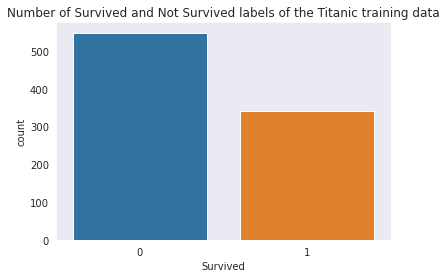

In [5]:

# Add title
plt.title("Number of Survived and Not Survived labels of the Titanic training data")
# Create count plot from Survived column
sns.countplot(train_data_full['Survived'])


In [6]:
# Show percentage of survived to get a better understanding
train_data_full['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

We notice that only around 38.4% of the people survived the Titanic disaster, which already gives an important overview of the target distribution 

# Data Analysis and Feature Selection

In this section, a more detailed analysis of the data is performed which is necessary to undestand which features might have the biggest impact on the prediced labels

## Sex

As can be seen from the plot below, the survival rate of women was almost 4 times that of men. This indicates that the Sex column holds a very important feature that strongly affects the label of the data

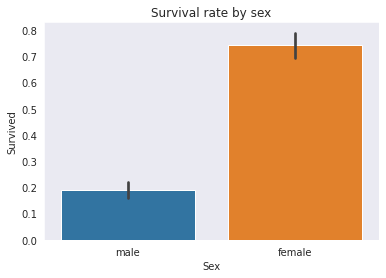

In [7]:
# Investigating how the sex of a passenger affected the survival
plt.title("Survival rate by sex")
sns.barplot(x='Sex', y='Survived',data=train_data_full)

## Age

Altough this column contains a lot of missing values, we can still try to extract meaningful information by plotting the age distribution in the training data, for both the Survived and Not Survived class.   

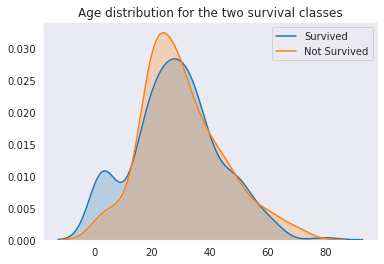

In [8]:
# Combined KDE plot with the age distribution of each class
plt.title("Age distribution for the two survival classes")
sns.kdeplot(train_data_full['Age'].loc[train_data_full["Survived"] == 1 ], shade=True, label="Survived")
sns.kdeplot(train_data_full['Age'].loc[train_data_full["Survived"] == 0 ], shade=True, label="Not Survived")

We notice that by itself, the Age feature is not very informative. The average age in the data is around 30 years old, both for survivals and non survivals. A small difference is noticed in small ages below 10 years old where there is a peak corresponding to young passengers who survived. We can try to see how this feature affects the target labels by combining it with another feature, such as the Sex of the passenger. Since we want to combine a numerical feature (Age) with a categorical (Sex), we will use a swarmplot as can be seen below:  

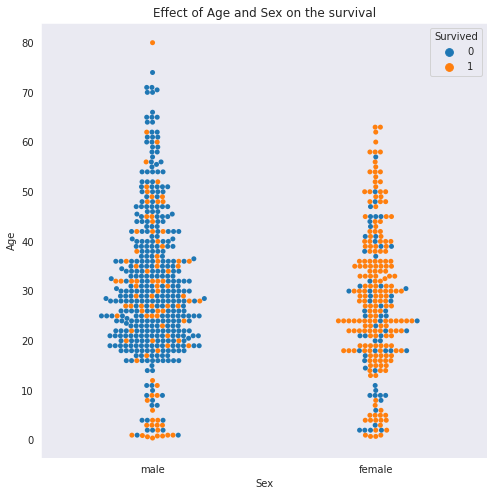

In [9]:
# Swarmplot showing how the Age and Sex of a passenger affected his survival
plt.figure(figsize=(8,8))
plt.title("Effect of Age and Sex on the survival")
sns.swarmplot(x="Sex", y="Age", hue = "Survived", data=train_data_full)

From the above swarmplot we notice a concentration of survived data points for males under 10 years of age, while for the females there are no particular properties. This shows that while women were in general more likely to survive independent of their age, only young males of 10 years or less had a good chance of survival.  

## Passenger class (Pclass)

We expect this feature to also be important for the target prediction, so we have a closer look into it here. We start by printing the relative frequencies of the unique Pclass values: 

In [10]:
# Percentage of Pclass values
train_data_full['Pclass'].value_counts(normalize=True)

3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64

We notice that around 55% of the passengers were in the third class, with 24% being in the second and 20% in the first. But how does this correlate to the survival rate? To see this we can group the data by Pclass and check the Survival label: 

In [11]:
# Survival rate by passenger class
train_data_full.groupby('Pclass').Survived.mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

First class passengers have the highest survival rate with almost 63%, while almost half of the second class passengers were able to survive. However, only 1 out of 4 third class passengers survived the Titanic disaster. Similar to what we did above, we can also combine the Pclass with the Sex feature to get better insignts, since both of these features are quite informative:

In [12]:
# Survival rate based on Pclass and Sex
train_data_full.groupby(['Pclass', 'Sex']).Survived.mean()

Pclass  Sex   
1       female    0.968085
        male      0.368852
2       female    0.921053
        male      0.157407
3       female    0.500000
        male      0.135447
Name: Survived, dtype: float64

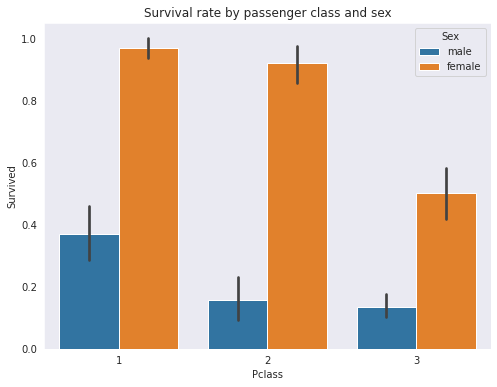

In [13]:
# Survival rate based on Pclass and Sex
plt.figure(figsize=(8,6))
plt.title("Survival rate by passenger class and sex")
sns.barplot(x="Pclass",y="Survived", hue="Sex", data=train_data_full)

The results above provide some quite interesting insights. First and second class women had a very high survival rate of 97% and 92%, respectively, while the percentage drops to 50% for women travelling in third class. Despite that, third class women had a higher survival rate than first class men, which shows again the important of the Sex feature for the survival. 

## Fare

As with previous features, we start by looking the various values of this feature:

In [14]:
# Max, min and average fare values
print('Highest Fare was:',train_data_full['Fare'].max())
print('Lowest Fare was:',train_data_full['Fare'].min())
print('Average Fare was:',train_data_full['Fare'].mean())

Highest Fare was: 512.3292
Lowest Fare was: 0.0
Average Fare was: 32.2042079685746


We can directly notice a weird property of this feature, since some Fare values are zero. We can have a closer look by checking into all the passengers with zero fare value:

In [15]:
# Subset of training data with zero Fare value
train_data_full.loc[train_data_full["Fare"] == 0.0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


Since even some first class passengers appear to have zero Fare values, this is clearly a mistake that must be corrected. As a first correction step, the zero values in the Fare column of the training and test sets will be replaced by NaN values. These will later be imputed, during the data preprocessing stage of this Notebook.

In [16]:
train_data_full["Fare"].replace(0.0, np.nan, inplace=True)
test_data_full["Fare"].replace(0.0, np.nan, inplace=True)
# Check if zero Fares have been eliminated
print('Number of zero Fares: {:d}'.format(train_data_full.loc[train_data_full["Fare"]==0].shape[0]))

Number of zero Fares: 0


After having replaced the zero Fare vaues by NaN, we plot below the relationship of this feature with the Survived label. Since there are many different fare values, we discretize them into four main categories, low, medium, high and very high.

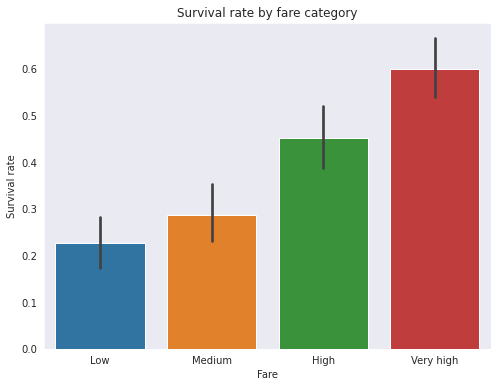

In [17]:
plt.figure(figsize=(8,6))
fare_ranges = pd.qcut(train_data_full.Fare, 4, labels = ['Low', 'Medium', 'High', 'Very high'])
plt.title('Survival rate by fare category')
g = sns.barplot(x=fare_ranges, y=train_data_full.Survived).set_ylabel('Survival rate')

As expected, the higher the fare, the higher the survival probability.

## Embarked

This column tells us where the passenger embarked the ship from. As described in the Data section of the competition, there are three possible values, C = Cherbourg, Q = Queenstown and S = Southampton. It is not easy to see how this feature might affect the survival, so we try to get some ideas about this with the following plots:

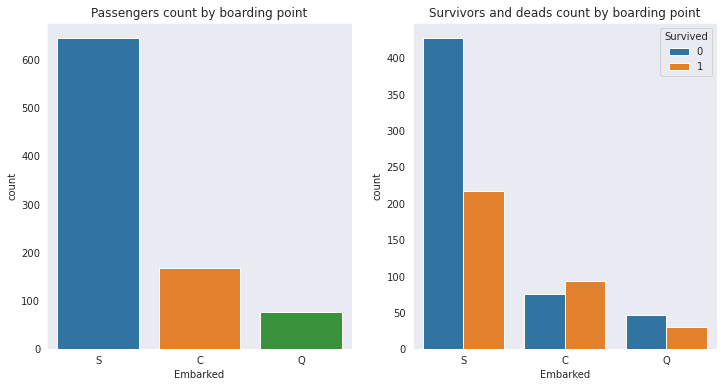

In [18]:
fig, axarr = plt.subplots(1,2,figsize=(12,6))
sns.countplot(train_data_full['Embarked'], ax=axarr[0]).set_title('Passengers count by boarding point')
p = sns.countplot(x = 'Embarked', hue = 'Survived', data = train_data_full, ax=axarr[1]).set_title('Survivors and deads count by boarding point')

In the training data, more than 70% of the people boarded from Southampton, slightly under 20% from Cherbourg and the rest from Queenstown.
Counting survivors by boarding point, we see that more people who embarked from Cherbourg survived than those who died.
Since we don't expect that a passenger's boarding point could change the chance of surviving, we guess this is probably due to the higher proportion of first and second class passengers for those who came from Cherbourg rather than Queenstown and Southampton.
To check this, we see the class distribution for the different embarking points.

Text(0.5, 1.0, 'Pclass count by embarking point')

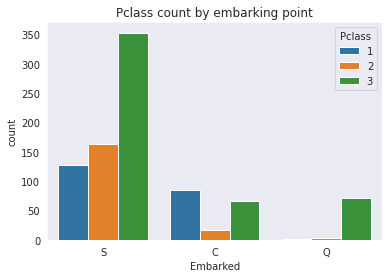

In [19]:
sns.countplot(data=train_data_full, x='Embarked', hue='Pclass').set_title('Pclass count by embarking point')

Indeed, it appears that the reason behind the high Cherbourg survival rate is the high proportion of first and second class passengers

## SibSp

This feature holds the number of siblings or spouses aboard the titanic. In order to decide if this feature will be useful for the training of our model, we investigate its relationship with the Survived label

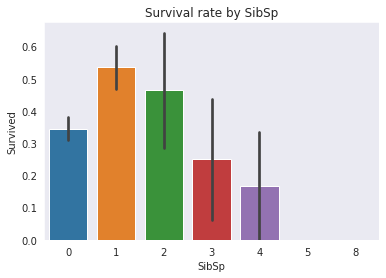

In [20]:
plt.title("Survival rate by SibSp")
sns.barplot(x='SibSp', y='Survived',data=train_data_full)

We see that the chances of surviving are lower for those who traveled alone or with more than 2 siblings. Furthermore, we notice that no one from a big family with 5 or 8 siblings was able to survive.

## Parch

Here we investigate how the Parch column, which holds the number of parents or children above the Titanic, relates to the survival rate. It is expected that we see a similar relation as in the SibSp feature.

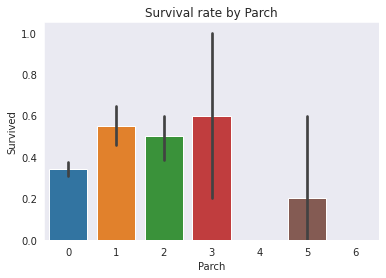

In [21]:
plt.title("Survival rate by Parch")
sns.barplot(x="Parch",y="Survived", data=train_data_full)

As expected, from the plot above we note that small families had more chances to survive than bigger ones and passengers who traveled alone. 

## Family type (generated from SibSp + Parch)

Since the two features examined above, SibSp and Parch, have very similar correlation to the survival rate and also provide related information, we can combine them into a single, more informative feature. Since the original features are on the same scale (0-10), we can combine them as seen below:

In [22]:
# Creation of a new Fam_size column which is the sum of SibSp, Parch and 1 (the passenger himself).
train_data_full['Fam_size'] = train_data_full['SibSp'] + train_data_full['Parch'] + 1
test_data_full['Fam_size'] = test_data_full['SibSp'] + test_data_full['Parch'] + 1

We can now plot the relation of this new feature with respect to the survival rate. The plot below shows in a more consice way the insights we got from Parch and SibSp; small families between 2 and 4 people have the higher survival chances, followed by Solo passengers while the survival rate drops from bigger families and is zero for very big families of 8 or 11 people.  

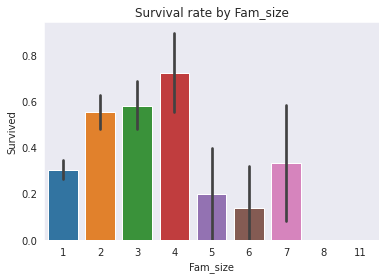

In [23]:
plt.title("Survival rate by Fam_size")
sns.barplot(x="Fam_size",y="Survived", data=train_data_full)

To further summarize this trend, we create a Fam_type feature from Fam_size, which however has less discrete values than Fam_size: Solo(1), Small(2-4), Big(5-7) and Very Big(8,11):

In [24]:
# Creation of four groups
train_data_full['Fam_type'] = pd.cut(train_data_full.Fam_size, [0,1,4,7,11], labels=['Solo', 'Small', 'Big', 'Very big'])
test_data_full['Fam_type'] = pd.cut(test_data_full.Fam_size, [0,1,4,7,11], labels=['Solo', 'Small', 'Big', 'Very big'])

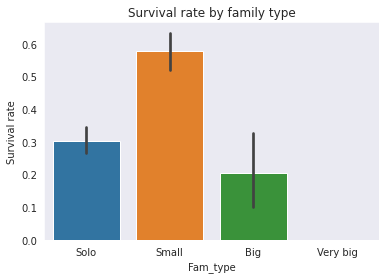

In [25]:
plt.title('Survival rate by family type')
g = sns.barplot(x=train_data_full.Fam_type, y=train_data_full.Survived).set_ylabel('Survival rate')

## Name

This feature might seem to have no relation to the survival rate. However, after a closer look one can see that the name of each passenger includes also his/her title (Mr, Miss etc). Based on our analysis above and especially the Sex and Pclass features, we expect the Title feature to be informative in a similar manner and of course much more informative than the general Name feature. Therefore, in this section we aim to generate a new feature called Title, based on the Name feature:

In [26]:
train_data_full['Title'] = train_data_full['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
test_data_full['Title'] = test_data_full['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [27]:
train_data_full['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Mlle              2
Col               2
the Countess      1
Ms                1
Lady              1
Jonkheer          1
Mme               1
Sir               1
Don               1
Capt              1
Name: Title, dtype: int64

In [28]:
test_data_full['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Dr          1
Ms          1
Dona        1
Name: Title, dtype: int64

Looking at the distribution of the titles, it might be convenient to move the really low-frequency ones into bigger groups.
After analyzing them, we substitute all rare female titles with Miss and all rare male titles with Mr.

In [29]:
# Substitute rare female titles
train_data_full['Title'].replace(['Mme', 'Ms', 'Lady', 'Mlle', 'the Countess', 'Dona'], 'Miss', inplace=True)
test_data_full['Title'].replace(['Mme', 'Ms', 'Lady', 'Mlle', 'the Countess', 'Dona'], 'Miss', inplace=True)
# Substitute rare male titles
train_data_full['Title'].replace(['Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer'], 'Mr', inplace=True)
test_data_full['Title'].replace(['Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer'], 'Mr', inplace=True)

After creating this new feature, we examine its relation to the survival rate:

In [30]:
train_data_full.groupby('Title').Survived.mean()

Title
Dr        0.428571
Master    0.575000
Miss      0.707447
Mr        0.160000
Mrs       0.792000
Rev       0.000000
Name: Survived, dtype: float64

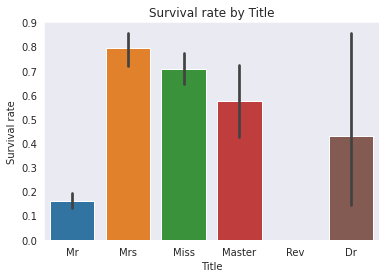

In [31]:
plt.title('Survival rate by Title')
g = sns.barplot(x='Title', y='Survived', data=train_data_full).set_ylabel('Survival rate')

We note that we were able to create a new feature with a nice correlation to the survival rate. Female titles Mrs and Miss have the highest surival rates, followed by prestigious male Titles Master and Dr. A low survival rate of less than 20% is observed for the Title Mr while zero of the Rev (pastors) in the Titanic were able to survive, according to the training data

# Data preprocessing and Model creation

The first step before the model creation consists of selecting which features will be used in the training data:

In [32]:
# Separate labels from features
y = train_data_full.Survived

features = ['Pclass', 'Fare', 'Title', 'Embarked', 'Fam_type', 'Sex', 'Age']
X = train_data_full[features]

X.head()

,Pclass,Fare,Title,Embarked,Fam_type,Sex,Age
0,3,7.2500,Mr,S,Small,male,22.0
1,1,71.2833,Mrs,C,Small,female,38.0
2,3,7.9250,Miss,S,Solo,female,26.0
3,1,53.1000,Mrs,S,Small,female,35.0
4,3,8.0500,Mr,S,Solo,male,35.0


In the next step we need to handle the missing values in both numerical and categorical data. Pipelines will be used here to simplify the process

In [33]:
numerical_cols = ['Fare']
categorical_cols = ['Pclass', 'Title', 'Embarked', 'Fam_type', 'Sex']

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


In [34]:
# Bundle preprocessing and modeling with Random Forest 
titanic_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('model', RandomForestClassifier(random_state=0, n_estimators=500, max_depth=5))
                                  ])

# Preprocessing of training data, fit model 
titanic_pipeline.fit(X,y)

print('Cross validation score: {:.3f}'.format(cross_val_score(titanic_pipeline, X, y, cv=10).mean()))

We are now ready to make our predictions by simply calling the predict method on the test data.


In [36]:
X_test = test_data_full[features]
X_test.head()

,Pclass,Fare,Title,Embarked,Fam_type,Sex,Age
0,3,7.8292,Mr,Q,Solo,male,34.5
1,3,7.0000,Mrs,S,Small,female,47.0
2,2,9.6875,Mr,Q,Solo,male,62.0
3,3,8.6625,Mr,S,Solo,male,27.0
4,3,12.2875,Mrs,S,Small,female,22.0


In [37]:
# Preprocessing of test data and predictions generation
predictions = titanic_pipeline.predict(X_test)

In [38]:
# Create submission file
output = pd.DataFrame({'PassengerId': test_data_full.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print('Your submission was successfully saved!')

Your submission was successfully saved!
